In [2]:
import xarray as xr
from pathlib import Path
import platform
import yaml
import numpy as np
from ascat.read_native.ragged_array_ts import CellFileCollection
from tqdm import tqdm  # import tqdm for progress bar
import matplotlib.pyplot as plt
import rioxarray
from rasterio.warp import transform

## Plans

Now we want to match the Sentinel1 6km Equi7 grid to the Ascat 12.5km Fibonaccy grid. We just want to align the spatial resolution. We will not align the time dimension. We could use
- Nearest Neighbour (not super nice as we have 6km and 12.5km resolution)
- Some Interpolation Technique

When we look at the pixle size it would be recommended to use around nine 6km pixles from the rasta data for one 12.5km pixle in the point data.

sig_dc_linear_12p5_fibgrid = sig_dc_linear_6p25_fibgrid.nearest.neighbour

sig_dc_12p5_fibgrid = 10 * np.log10(sig_dc_linear_12p5_fibgrid)
sig_dc_12p5_fibgrid

### Loading Sentinel 1 data

In [3]:
sentinel_ds = xr.open_zarr("output_6km_filled.zarr")
sentinel_ds

<xarray.Dataset> Size: 6kB
Dimensions:      (time: 2, y: 21, x: 17)
Coordinates:
    spatial_ref  int32 4B ...
  * time         (time) datetime64[ns] 16B 2022-01-06T05:00:00 2022-01-07T17:...
  * x            (x) float64 136B 4.483e+06 4.489e+06 ... 4.576e+06 4.58e+06
  * y            (y) float64 168B 1.382e+06 1.376e+06 ... 1.264e+06 1.26e+06
Data variables:
    VH           (time, y, x) float32 3kB dask.array<chunksize=(1, 20, 16), meta=np.ndarray>
    VV           (time, y, x) float32 3kB dask.array<chunksize=(1, 20, 16), meta=np.ndarray>

In [ ]:
# get bounds for ASCAT data from S1

# is this a good approach? look at step 1 to see why

sentinel_ds = sentinel_ds.rio.write_crs(sentinel_ds.spatial_ref.attrs['crs_wkt'])

#bounds_proj = sentinel_ds.rio.bounds()

sentinel_ds_latlon = sentinel_ds.rio.reproject("EPSG:4326")
latmin = float(sentinel_ds_latlon.y.min())
latmax = float(sentinel_ds_latlon.y.max())
lonmin = float(sentinel_ds_latlon.x.min())
lonmax = float(sentinel_ds_latlon.x.max())

print(f"latmin: {latmin}, latmax: {latmax}")
print(f"lonmin: {lonmin}, lonmax: {lonmax}")

latmin: 43.92326671136945, latmax: 45.09195053816223
lonmin: 6.779846242494321, lonmax: 8.208237586352164


We can see that we do not get the exact defined lat and lon we defined but a slightly bigger area. This should not be a problem in our further analysis.

### Reading ASCAT data points

In [5]:
# read yaml for reading data on Windows, Linux or the JupyterHub
paths = yaml.safe_load(Path("../paths.yml").read_text())
root = Path(paths["windows" if platform.system() == "Windows" else "linux"]).expanduser()
cell_source = root / "datasets/scat_ard/ascat_ssm_cdr_12.5km_h121"
assert cell_source.exists(), f"Path does not exist: {cell_source}"

### Is this the typical way of loading ASCAT?
### In which dataformat do we work with ASCAT data? is it a xarray dataset?


In [6]:
h121_reader = CellFileCollection.from_product_id(cell_source, "H121_V1.0")
gpis, lons, lats, cells = h121_reader.grid.get_grid_points()

indices = np.where(
    (lats >= latmin) & (lats <= latmax) & (lons >= lonmin) & (lons <= lonmax)
)[0]

print("There are", len(indices), "point indices inside specified bounding box")

selected_coords = list(zip(lons[indices], lats[indices]))
selected_gpis = gpis[indices]

datasets = []

for id in tqdm(selected_gpis, desc="Loading locations"):
    ds = h121_reader.read(location_id=id)
    ds = ds.swap_dims({"obs": "time"})
    
    ds_single_time = ds.isel(time=0)
    
    # Expand dims to keep consistent shape for concatenation
    ds_single_time = ds_single_time.expand_dims(location_id=[id])
    datasets.append(ds_single_time)

ascat_ds = xr.concat(datasets, dim="location_id")
ascat_ds

c:\Users\jwagner\AppData\Local\anaconda3\envs\ascat-s1-synergy\lib\site-packages\ascat\read_native\ragged_array_ts.py:945: UserWarning: Could not determine date range for collection 'ascat_ssm_cdr_12' from directory name. Using min/max datetime from files instead.
  warnings.warn(


There are 95 point indices inside specified bounding box


Loading locations: 100%|██████████| 95/95 [02:27<00:00,  1.55s/it]


<xarray.Dataset> Size: 8kB
Dimensions:                            (location_id: 95)
Coordinates:
  * location_id                        (location_id) int32 380B 1140858 ... 1...
    lon                                (location_id) float32 380B 7.321 ... 8...
    lat                                (location_id) float32 380B 43.94 ... 4...
    alt                                float32 4B 9.969e+36
    time                               (location_id) datetime64[ns] 760B 2007...
Data variables: (12/20)
    locationIndex                      (location_id) int32 380B 1172 1175 ... 24
    location_description               (location_id) <U1 380B '' '' '' ... '' ''
    as_des_pass                        (location_id) int8 95B 0 0 0 0 ... 0 0 0
    swath_indicator                    (location_id) int8 95B 1 1 1 1 ... 1 1 1
    surface_flag                       (location_id) uint8 95B 0 0 0 0 ... 0 0 0
    surface_soil_moisture              (location_id) float32 380B 56.28 ... 5...
    ...                                 ...
    snow_cover_probability             (location_id) float64 760B 97.0 ... 36.0
    frozen_soil_probability            (location_id) float64 760B 36.0 ... 26.0
    wetland_fraction                   (location_id) int8 95B 0 0 0 0 ... 0 1 0
    topographic_complexity             (location_id) int8 95B 32 20 26 ... 24 4
    subsurface_scattering_probability  (location_id) float64 760B nan ... nan
    sat_id                             (location_id) int8 95B 3 3 3 3 ... 3 3 3
Attributes:
    id:            1358.nc
    date_created:  2025-01-09 12:40:43
    featureType:   timeSeries

### Mapping the Sentinel 1 data 
We want to map the data to the Fibonaccy Pointgrid to match the 12.5km resolution ASCAT data

Possible approaches:
- Nearest neighbour (but resolution does not seem to be that nice) -> should i increase the sentinel resolution?
- Interpolation

#### Step 1
Reproject the ASCAT points to the Sentinel 1 raster

In [7]:
ascat_points = ascat_ds.drop_vars(list(ascat_ds.data_vars))  # remove all data variables
ascat_points = ascat_points.drop_vars("time")           # remove time coordinate if present
ascat_points

<xarray.Dataset> Size: 1kB
Dimensions:      (location_id: 95)
Coordinates:
  * location_id  (location_id) int32 380B 1140858 1141091 ... 1164347 1164580
    lon          (location_id) float32 380B 7.321 8.012 6.894 ... 7.452 8.143
    lat          (location_id) float32 380B 43.94 43.95 43.95 ... 45.08 45.09
    alt          float32 4B 9.969e+36
Data variables:
    *empty*
Attributes:
    id:            1358.nc
    date_created:  2025-01-09 12:40:43
    featureType:   timeSeries

#### Step 2
Sample raster values at the coordinates of the points using nearest neighbour

#### Step 3
Attach samples values to the ascat points

### Old stuff


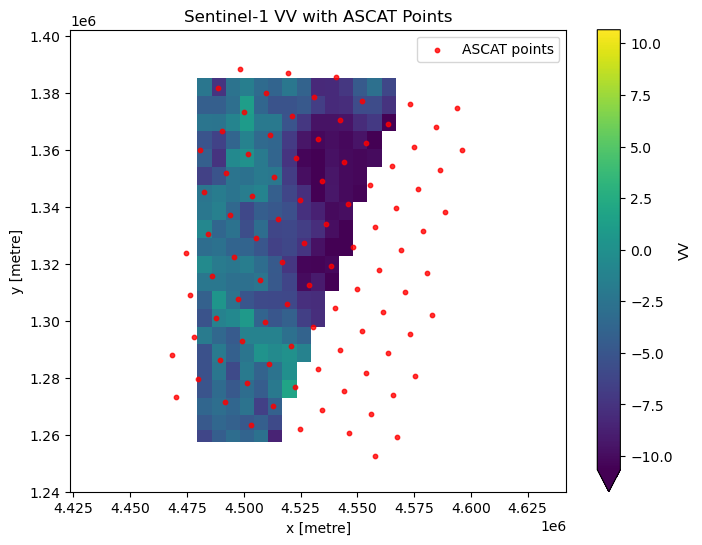

In [ ]:
# old approach crs is not the same i think

ascat_crs = "EPSG:4326"                        # ASCAT in geographic coordinates
sentinel_crs = sentinel_ds.rio.crs.to_string() # Sentinel-1 in projected CRS (e.g., EPSG:3035)

ascat_x, ascat_y = transform(
    src_crs=ascat_crs,
    dst_crs=sentinel_crs,
    xs=ascat_ds["lon"].values,
    ys=ascat_ds["lat"].values,
)


# check transtormation of ascat points on sentinel data

vv_img = sentinel_ds["VV"].isel(time=0)

fig, ax = plt.subplots(figsize=(8, 6))
vv_img.plot(ax=ax, cmap="viridis", robust=True)
ax.scatter(ascat_x, ascat_y, s=10, c='red', label="ASCAT points", alpha=0.8)
ax.set_xlim(0.99*min(np.min(ascat_x), sentinel_ds.x.min().item()), 
            1.01*max(np.max(ascat_x), sentinel_ds.x.max().item()))
ax.set_ylim(0.99*min(np.min(ascat_y), sentinel_ds.y.min().item()), 
            1.01*max(np.max(ascat_y), sentinel_ds.y.max().item()))
ax.set_title("Sentinel-1 VV with ASCAT Points")
ax.legend()
plt.show()